# 3-6. 予測・判断 - 決定木（Decision Tree）、ランダムフォレスト、混同行列、Accuracy、Precision、Recall

「3-4. 深層学習の基礎と展望」で扱ったのと同様のデータセットに対して，今度は深層学習ではないさまざまな分類モデルを適応させていく．
[メディア芸術データベース・ラボ](https://mediag.bunka.go.jp/madb_lab/)上のサービスを利用して取得したデータを用いて，簡単な分類を行う決定木・ランダムフォレストのサンプルコードを見ていこう．


データベース上からゲームパッケージを取得し，「発行者」「公開年月日」「対象年齢（CERO）」を特徴量化して，どのプラットフォームに該当するゲームなのかを当てる多クラス分類モデルを作っていく．


### データの取得
[メディア芸術データベース・ラボ](https://mediag.bunka.go.jp/madb_lab/)上で提供されている[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)を利用して，ゲームパッケージのデータを取得していく．



以下のコードを[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)上に入力して実行する，または入力を省略した[こちらのURL](https://mediag.bunka.go.jp/madb_lab/lod/sparql/#query=PREFIX%20ma%3A%20%3Chttps%3A%2F%2Fmediaarts-db.bunka.go.jp%2Fdata%2Fproperty%23%3E%0APREFIX%20rdfs%3A%20%20%20%3Chttp%3A%2F%2Fwww.w3.org%2F2000%2F01%2Frdf-schema%23%3E%0APREFIX%20schema%3A%20%3Chttps%3A%2F%2Fschema.org%2F%3E%20SELECT%20%3F%E3%83%A9%E3%83%99%E3%83%AB%20%3F%E7%99%BA%E8%A1%8C%E8%80%85%20%3F%E3%83%97%E3%83%A9%E3%83%83%E3%83%88%E3%83%95%E3%82%A9%E3%83%BC%E3%83%A0%20%3F%E3%83%AC%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5%0AWHERE%20%7B%0A%20%20%3F%E3%82%A2%E3%82%A4%E3%83%86%E3%83%A0%0A%20%20%20%20%20%20%20%20schema%3Agenre%20%22%E3%82%B2%E3%83%BC%E3%83%A0%E3%83%91%E3%83%83%E3%82%B1%E3%83%BC%E3%82%B8%22%3B%0A%20%20%20%20%20%20%20%20schema%3AcontentRating%20%3F%E3%83%AC%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%3B%0A%20%20%20%20%20%20%20%20schema%3AgamePlatform%20%3F%E3%83%97%E3%83%A9%E3%83%83%E3%83%88%E3%83%95%E3%82%A9%E3%83%BC%E3%83%A0%3B%0A%20%20%20%20%20%20%20%20schema%3Apublisher%20%3F%E7%99%BA%E8%A1%8C%E8%80%85%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3F%E3%83%A9%E3%83%99%E3%83%AB%3B%0A%20%20%20%20%20%20%20%20ma%3AdatePublished%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5.%0A%7D&endpoint=https%3A%2F%2Fmediag.bunka.go.jp%2Fsparql&requestMethod=POST&tabTitle=Query&headers=%7B%7D&contentTypeConstruct=application%2Fn-triples%2C*%2F*%3Bq%3D0.9&contentTypeSelect=application%2Fsparql-results%2Bjson%2C*%2F*%3Bq%3D0.9&outputFormat=table)から実行してデータを取得できる．
取得したCSVファイルを「ゲームパッケージ.csv」として保存し，このノートブック上にアップロードしよう．

※「3-4. ディープニューラルネットワーク（DNN）」，「3-4. 学習用データと学習済みモデル」，「3-6. サポートベクターマシン」，「3-7. 形態素解析」，「3-7. かな漢字変換」，「3-7. 表現学習」と同じデータセットを作成するため，もし同じものを持っている場合は以下の取得作業は不要なので，そちらをアップロードしよう．
```
PREFIX ma: <https://mediaarts-db.bunka.go.jp/data/property#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/> SELECT ?ラベル ?発行者 ?プラットフォーム ?レーティング ?公開年月日
WHERE {
  ?アイテム
        schema:genre "ゲームパッケージ";
        schema:contentRating ?レーティング;
        schema:gamePlatform ?プラットフォーム;
        schema:publisher ?発行者;
        rdfs:label ?ラベル;
        ma:datePublished ?公開年月日.
}
```

取得したデータセットを，Python上で扱いやすい形にしていく．
pandasというライブラリを用いて，csv形式のファイルの中身をDataFrameという型に変換し，扱っていく．

In [ ]:
import pandas as pd
import collections
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
games = pd.read_csv("/content/ゲームパッケージ.csv")
games = games.drop_duplicates()
games = games.reset_index(drop=True)
games

ラベル  \
0                           Dance Dance Revolution GB2   
1                                     プロ野球 ファミスタ リターンズ   
2                                      プロ野球 ファミスタ 2011   
3                                              フロッガー3D   
4                                           ブレイブリーセカンド   
...                                                ...   
21976                 バイオショック インフィニット PlayStation Now版   
21977  バイオハザード リベレーションズ アンベールド エディション PlayStation Now版   
21978                           巫剣神威控 PlayStation Now版   
21979                 ネバーエンディング ナイトメア PlayStation Now版   
21980                   雷電IV OverKill PlayStation Now版   

                           発行者       プラットフォーム            レーティング       公開年月日  
0                      コナミ株式会社         ゲームボーイ  CERO D (17才以上対象)  2000-11-16  
1        株式会社バンダイナムコエンターテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2015-10-08  
2              株式会社バンダイナムコゲームス      ニンテンドー3DS    CERO A (全年齢対象)  2011-03-31  
3         株式会社コナミデジタルエンタテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2011-09-22  
4              株式会社スクウェア・エニックス      ニンテンドー3DS  CERO C (15才以上対象)  2015-04-23  
...                        ...            ...               ...         ...  
21976  テイクツー・インタラクティブ・ジャパン合同会社  プレイステーション Now  CERO D (17才以上対象)  2017-09-19  
21977                 株式会社カプコン  プレイステーション Now  CERO D (17才以上対象)  2016-09-20  
21978           アクティブゲーミングメディア  プレイステーション Now  CERO C (15才以上対象)  2017-07-20  
21979           アクティブゲーミングメディア  プレイステーション Now  CERO D (17才以上対象)  2017-07-20  
21980                       モス  プレイステーション Now    CERO A (全年齢対象)  2017-02-21  

[21981 rows x 5 columns]

## データクレンジング
想定外の値を持つデータを除外する作業をする．
例えば，`games`の["公開年月日"]列には`yyyy-mm-dd`の形式で日付が入っていることが期待されるが，そうでない形式のものが含まれている可能性もある．
実際に見てみよう．

In [ ]:
for day in games['公開年月日']:
  if len(day) < 10:
    print(day)

2007
2000
2009
2002
2006
2006
2006
2001
2014
2002
1999
1998
2007
2003
2008
2001
2003
2013
2017
2001
2002
2001
2005
1998
1998
2006


こういったものを先に除外しておくと，後の計算が楽に正しく行えるようになる．


In [ ]:
games = games[games['公開年月日'].str.len() >= 10]
games

ラベル  \
0                           Dance Dance Revolution GB2   
1                                     プロ野球 ファミスタ リターンズ   
2                                      プロ野球 ファミスタ 2011   
3                                              フロッガー3D   
4                                           ブレイブリーセカンド   
...                                                ...   
21976                 バイオショック インフィニット PlayStation Now版   
21977  バイオハザード リベレーションズ アンベールド エディション PlayStation Now版   
21978                           巫剣神威控 PlayStation Now版   
21979                 ネバーエンディング ナイトメア PlayStation Now版   
21980                   雷電IV OverKill PlayStation Now版   

                           発行者       プラットフォーム            レーティング       公開年月日  
0                      コナミ株式会社         ゲームボーイ  CERO D (17才以上対象)  2000-11-16  
1        株式会社バンダイナムコエンターテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2015-10-08  
2              株式会社バンダイナムコゲームス      ニンテンドー3DS    CERO A (全年齢対象)  2011-03-31  
3         株式会社コナミデジタルエンタテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2011-09-22  
4              株式会社スクウェア・エニックス      ニンテンドー3DS  CERO C (15才以上対象)  2015-04-23  
...                        ...            ...               ...         ...  
21976  テイクツー・インタラクティブ・ジャパン合同会社  プレイステーション Now  CERO D (17才以上対象)  2017-09-19  
21977                 株式会社カプコン  プレイステーション Now  CERO D (17才以上対象)  2016-09-20  
21978           アクティブゲーミングメディア  プレイステーション Now  CERO C (15才以上対象)  2017-07-20  
21979           アクティブゲーミングメディア  プレイステーション Now  CERO D (17才以上対象)  2017-07-20  
21980                       モス  プレイステーション Now    CERO A (全年齢対象)  2017-02-21  

[21955 rows x 5 columns]

また，取得したデータのうち目標クラスとなるゲームプラットフォームはどれくらいの種類があって，それぞれどれくらいの要素数を持つのか確認してみよう．

In [ ]:
count = collections.Counter(games["プラットフォーム"])
count

Counter({'ゲームボーイ': 1,
         'ニンテンドー3DS': 1993,
         'Xbox One': 645,
         'プレイステーション4': 1712,
         'プレイステーション・ポータブル': 3101,
         'Xbox 360': 738,
         'プレイステーション Vita': 1979,
         'プレイステーション3': 2307,
         'ドリームキャスト': 326,
         'セガサターン': 397,
         'Wii U': 817,
         'メガドライブ': 2,
         'ゲームボーイアドバンス': 233,
         'Wii': 998,
         'ニンテンドーDS': 2050,
         'ゲームアーカイブス': 945,
         'プレイステーション': 12,
         'プレイステーション2': 2707,
         'PCエンジン': 2,
         'Nintendo Switch': 315,
         'Microsoft Windows': 223,
         'macOS': 13,
         'ワンダースワン': 1,
         'ゲームギア': 5,
         'Xbox': 78,
         'ニンテンドーゲームキューブ': 128,
         '3DO': 54,
         'PC-FX': 3,
         'プレイステーション Now': 170})

極端に少ない要素数のクラスを含めると，約30クラスもの分類問題になってしまう．
問題設定を簡単にするため，要素数の多い（100個以上）家庭用ゲーム機の据置機のみに絞ることとする．

In [ ]:
new_classes = [key for key, value in count.items() if value >= 100]
new_classes = list(set(new_classes) & set(["プレイステーション", "プレイステーション2", "プレイステーション3", "プレイステーション4", "ニンテンドーゲームキューブ", "Wii", "Wii U", "Nintendo Switch", "Xbox", "Xbox 360", "Xbox One", "ドリームキャスト"]))
games = games[games['プラットフォーム'].isin(new_classes)]
collections.Counter(games["プラットフォーム"])



Counter({'Xbox One': 645,
         'プレイステーション4': 1712,
         'Xbox 360': 738,
         'プレイステーション3': 2307,
         'ドリームキャスト': 326,
         'Wii U': 817,
         'Wii': 998,
         'プレイステーション2': 2707,
         'Nintendo Switch': 315,
         'ニンテンドーゲームキューブ': 128})

## データのベクトル化
データは揃ったが，このままタイトルや発行者などの文字列をモデルに直接入力することはできない．

そこで，今回特徴量にする情報群を，深層学習の章で用いたのと同じようにベクトル化していく．
（本来決定木ではカテゴリ変数をそのまま特徴量としてもいいのだが，性能比較の意味も込めて同じOne-hotベクトルによるエンコーディングで学習を行うこととする）

### 目標変数（クラス）のベクトル化
各ゲームプラットフォームをカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [ ]:
# ワンホットベクトルへのエンコードを行うインスタンスonehot_encoderの作成
onehot_encoder = OneHotEncoder(sparse = False,dtype = int)

# プラットフォームが何か？を表すワンホットベクトルへの学習・変換を同時に行う関数．変換後はyに格納
y = onehot_encoder.fit_transform(np.array(games['プラットフォーム']).reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 説明変数のベクトル化

#### 発行者のベクトル化
各会社をカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [ ]:
# 出版元がどこか？を表すワンホットベクトルへの学習・変換を同時に行う関数．変換後はcreatorsに格納
creators = onehot_encoder.fit_transform(np.array(games['発行者']).reshape(-1,1))
creators.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(10693, 756)

#### レートのベクトル化
各レートをカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [ ]:
# 対象年齢がどれか？を表すワンホットベクトルへの学習・変換を同時に行う関数．変換後はratesに格納
rates = onehot_encoder.fit_transform(np.array(games['レーティング']).reshape(-1,1))
rates.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(10693, 14)

#### 公開年月日のベクトル化
公開年/月/日というふうに３つのベクトルに分けて表現することにする．

In [ ]:
years = []
months = []
dates = []
for day in games['公開年月日']:
  y_m_d = day.split("-")
  years.append(int(y_m_d[0]))
  months.append(int(y_m_d[1]))
  dates.append(int(y_m_d[2]))

years = np.array(years).reshape(-1,1)
months = np.array(months).reshape(-1,1)
dates = np.array(dates).reshape(-1,1)

years.shape

(10693, 1)

#### 説明変数（特徴量）ベクトルの作成


In [ ]:
# 各特徴量を横並びに結合して，1つのゲームパッケージにつき1つの結合された特徴量ベクトルが対応するようにする
X = np.concatenate([creators, rates, years, months, dates], axis=1)

print(f"{X.shape[1]}次元の特徴量を持つデータが{X.shape[0]}件作成された．")

773次元の特徴量を持つデータが10693件作成された．



### 学習データとテストデータに分ける

In [ ]:
# デフォルトでは学習データは75%，テストデータは25%になる
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), shuffle=True)

## 決定木モデルの構築

上記で用意したデータセットを利用して，簡単な多クラス分類決定木モデルを作っていく．

In [ ]:
#　必要なモジュールの読み込み
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import sklearn.tree

決定木がどんなふうに分類を行っているのか，簡易化のために深さを3までに制限した決定木を作成し，プロットしてみよう．

正解率:  0.5003739715781601


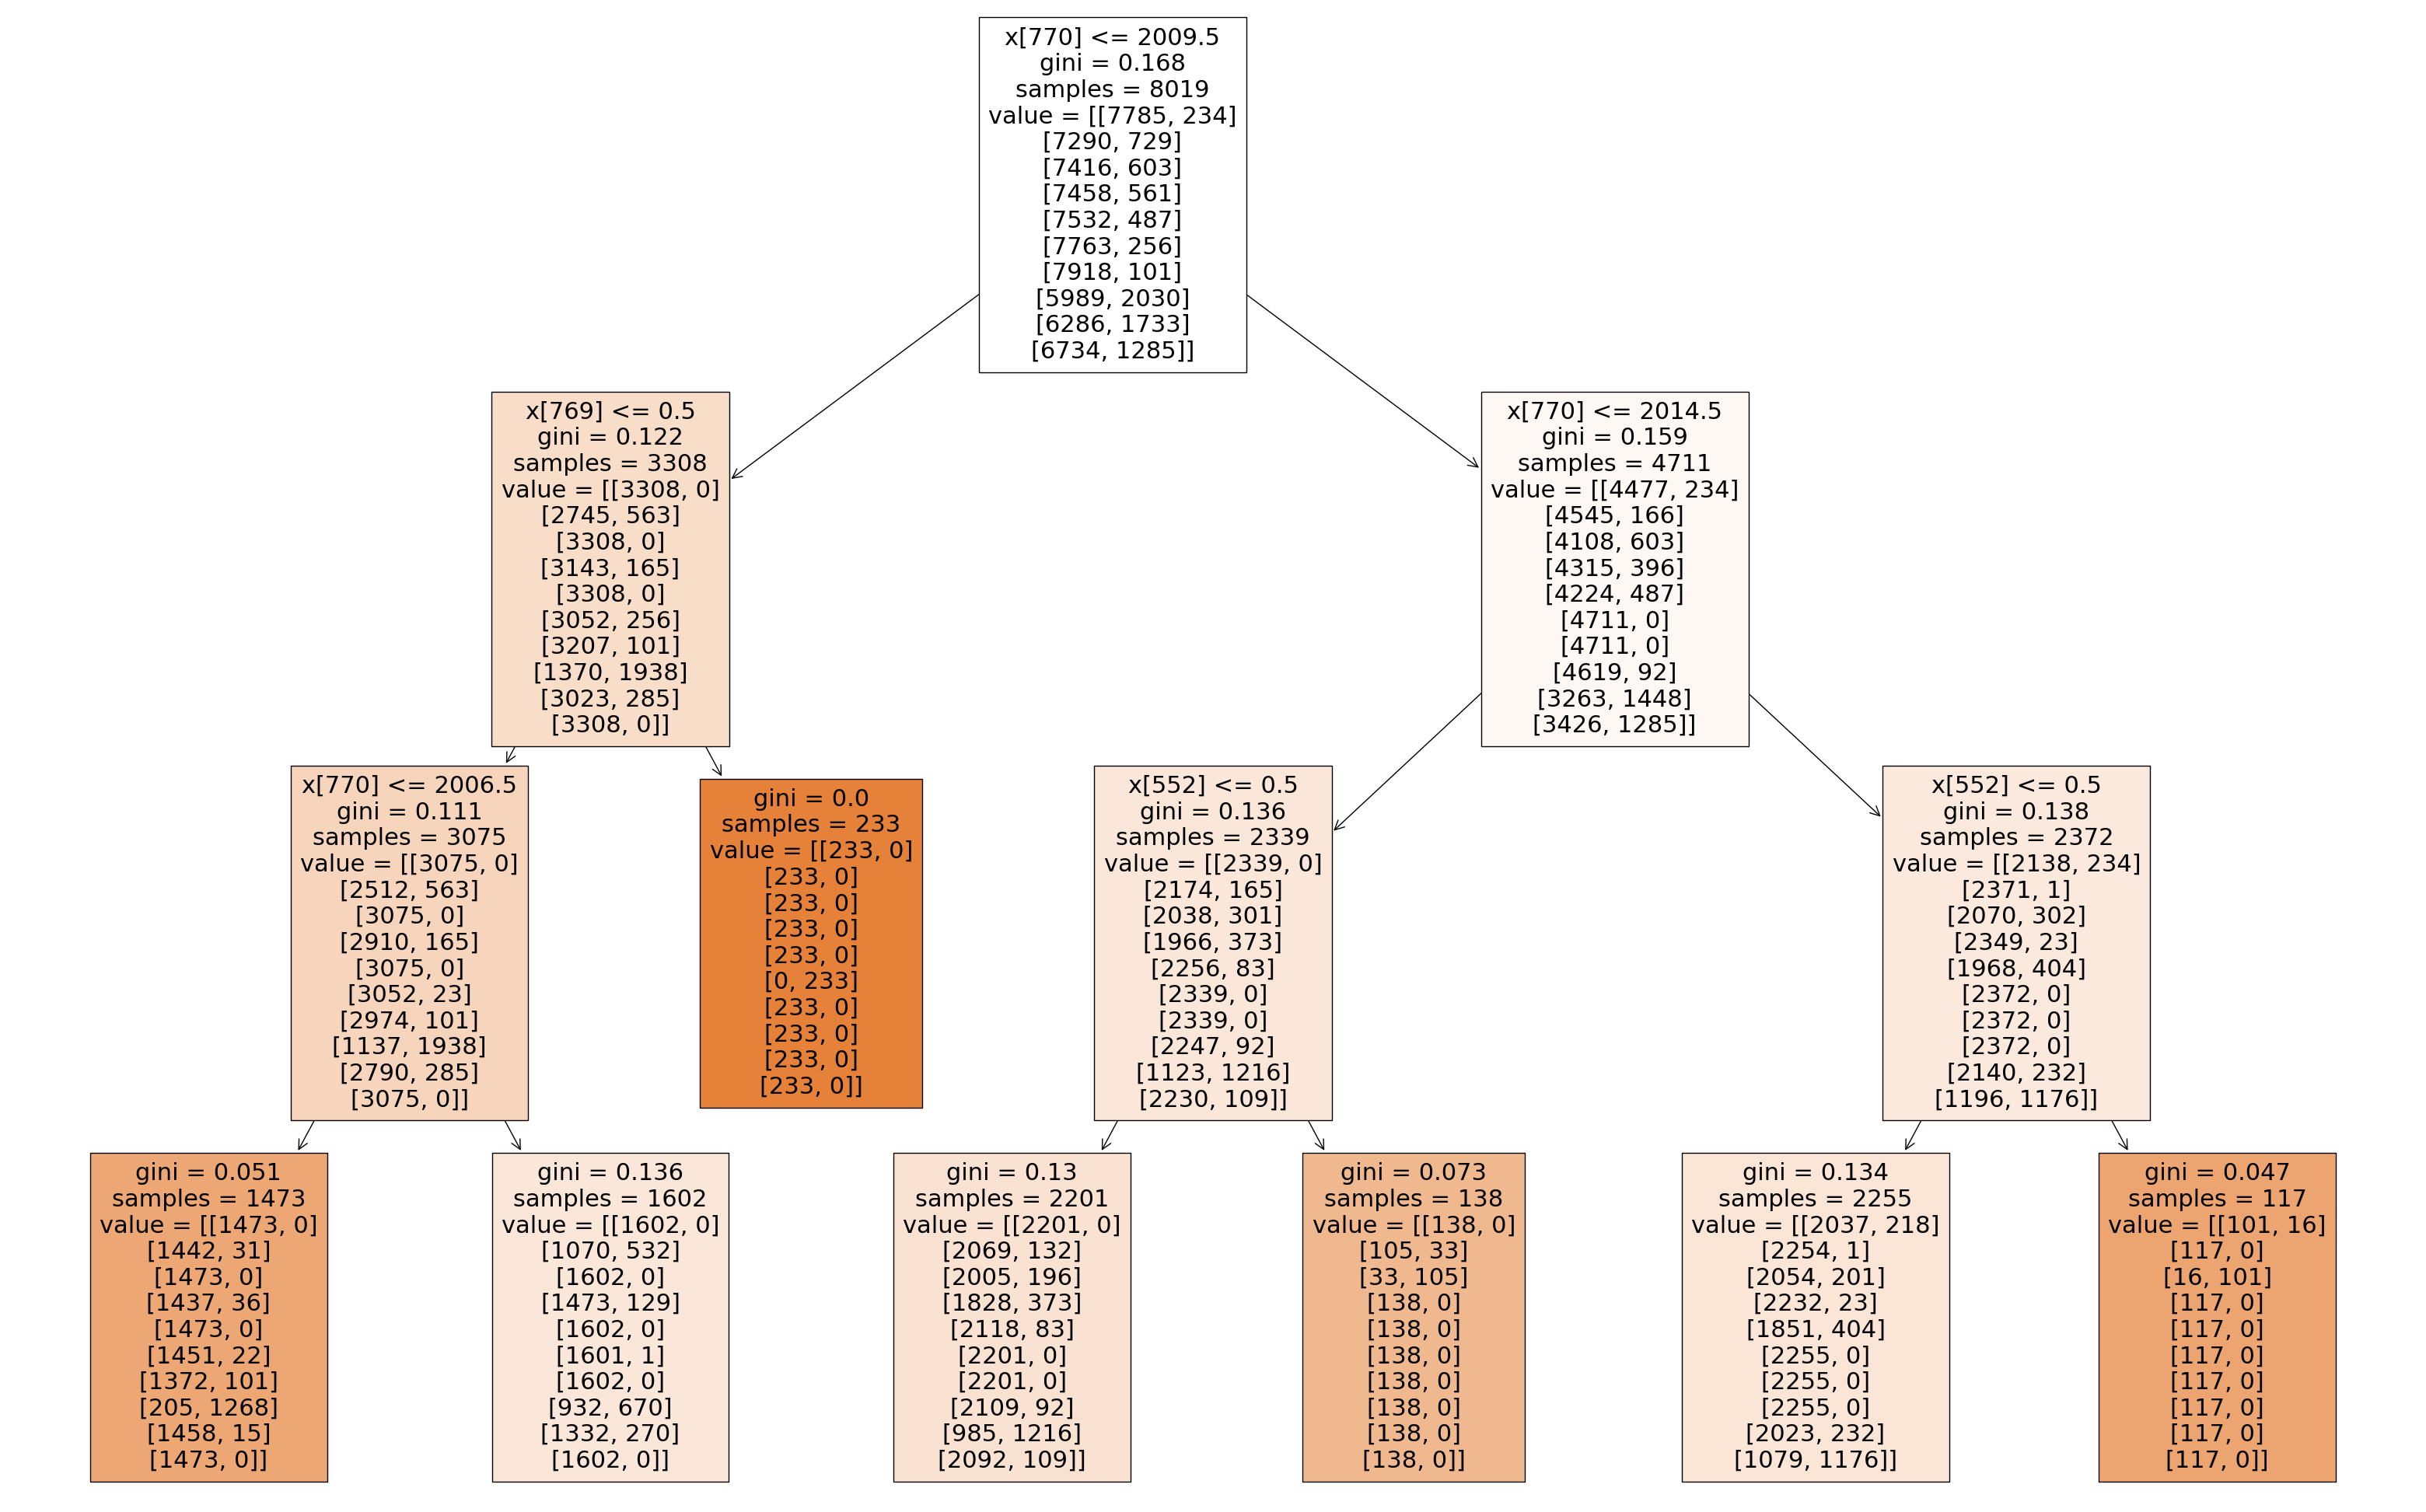

In [ ]:
tree = DecisionTreeClassifier(max_depth=3) #デフォルト値(None)では最大まで展開される
tree.fit(X_train, y_train)
print("正解率: ", tree.score(X_test, y_test))
# 決定木を可視化
plt.figure(figsize=(40, 25))
sklearn.tree.plot_tree(tree, # モデルの名前
                       class_names=["CERO A","CERO B","CERO C","CERO D","CERO Z"], # クラス名
                       filled=True # 色付きで表示
                       );

見てみると，各要素がある閾値以下かどうかで場合分けが進んでいる様子がわかる．
このような処理を何度も何度も繰り返すことで決定木は分類性能を向上させていく．
場合わけ処理の多さ=木の深さが深い方が訓練データでの正解率は上がるが，もちろん深いほどいいというわけではなく過学習の原因にもなりうるので，適切に深さを指定することも大切である．


max_depthを指定しなかった場合は正解率は以下のようになる．

In [ ]:
tree = DecisionTreeClassifier() #デフォルト(None)では最大まで展開される
tree.fit(X_train, y_train)
print("正解率: ", tree.score(X_test, y_test))
print("木の深さ: ", tree.get_depth())

正解率:  0.6387434554973822
木の深さ:  45


# 3-6. 予測・判断 - ランダムフォレスト

上記で用意したデータセットを利用して，決定木と同様に簡単な多クラス分類ランダムフォレストを作っていく．


ランダムフォレストとは複数の決定⽊（いわゆる“森”）を組合せることで推定精度を向上させる⼿法だが，Pythonでは決定木モデルを何個も作って学習していく必要はなく，こちらも`RandomForestClassifier`というライブラリがscikit-learnで用意されている．そのため，以下のように簡単に構築することができる．

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier() # デフォルトで100個の木の組み合わせ，最大まで展開される設定になっている
random_forest.fit(X_train, y_train)

print("正解率: ", random_forest.score(X_test, y_test))

正解率:  0.6537023186237846


# 3-6. 予測・判断 - 特徴量の効果的な選択
ランダムフォレストでは，各決定木モデルは全ての特徴量は使わずに学習しており，それらを組み合わせてモデル全体を学習していくため，どのモデルに重きを置くか=どの特徴量に重きを置くかということで重要な特徴量を選ぶということを行なっている．

構築したモデルが各特徴量についてどのように重要度を計算したのか見てみると，次のようになる．

In [ ]:
random_forest.feature_importances_

array([0.00000000e+00, 3.51990011e-05, 0.00000000e+00, 2.90741005e-04,
       1.70935270e-03, 2.67402190e-04, 1.06406329e-04, 1.20711627e-04,
       6.67389719e-04, 1.76063952e-04, 1.03937260e-03, 1.06439173e-04,
       6.94695325e-04, 3.93086042e-04, 0.00000000e+00, 4.63970805e-05,
       9.08230215e-05, 1.27164410e-04, 5.36967571e-05, 3.23234752e-05,
       2.70374343e-04, 0.00000000e+00, 5.85307278e-05, 3.79244306e-05,
       7.01888752e-05, 5.96210056e-05, 1.14912267e-03, 9.40738215e-05,
       1.06940309e-04, 0.00000000e+00, 6.16312553e-05, 1.75973773e-04,
       0.00000000e+00, 0.00000000e+00, 4.87358093e-05, 1.05506954e-04,
       4.91737107e-06, 2.58945966e-05, 2.28811936e-05, 1.50519604e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.31328222e-04,
       5.41322765e-05, 5.08557267e-05, 1.38027107e-04, 0.00000000e+00,
       6.94950085e-04, 2.33830304e-04, 9.55707679e-05, 1.24542233e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.70093723e-04,
      

いくつかの値が0になっている．つまり，この値はランダムフォレストの計算に関与しない無意味なベクトルであったことがわかる．

特徴量はむやみに多ければ良いというわけではないので，適切に選択する必要がある．

# 3-6. 予測・判断 - 混同行列、Accuracy、Precision、Recall


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

ここまでに作成してきた決定木・ランダムフォレストについて，モデルの評価を行ってみよう．

以下では分類モデルの評価を行う指標である混同行列・Accuracy・Precision・Recallを計算する手法について詳しく見ていく．

## 混同行列

縦軸・横軸に正解ラベル，予測ラベルのいずれかをとった行列で，縦軸に正解ラベルを取った場合であればi行j列目のxという値は，「決定木がクラス[j]と予測したもののうち，本当はラベル[i]のものがx個あった」ということを意味する． つまり，混同行列の左上から右下にかけての斜めのマスの値が大きく，それ以外の値が小さいモデルは良いモデルであると言える．

実際に混同行列を作成して比較してみよう．

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

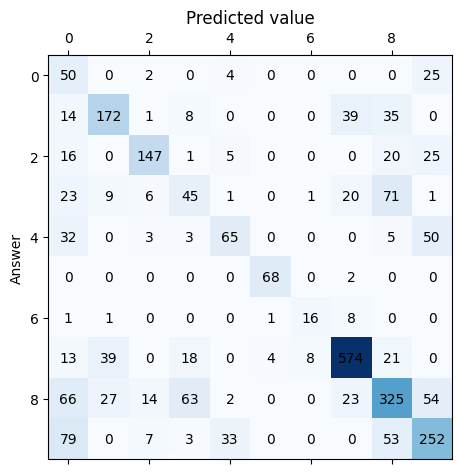

In [ ]:
# 決定木
# 予測値を作成
y_pred_tree = tree.predict(X_test)

# 混同行列を作成
conf_mat_tree = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_tree, axis=1)) # confusion_matrixはワンホットベクトルではなく整数値によるカテゴリしか受け付けないので，aumpyのargmaxを利用して変換している


# プロット
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat_tree, cmap=plt.cm.Blues)
for i in range(conf_mat_tree.shape[0]):
    for j in range(conf_mat_tree.shape[1]):
        ax.text(x=j, y=i, s=conf_mat_tree[i, j], va='center', ha='center')
plt.title('Predicted value')
plt.ylabel('Answer')
plt.rcParams["font.size"] = 15
plt.tight_layout()
plt.show()


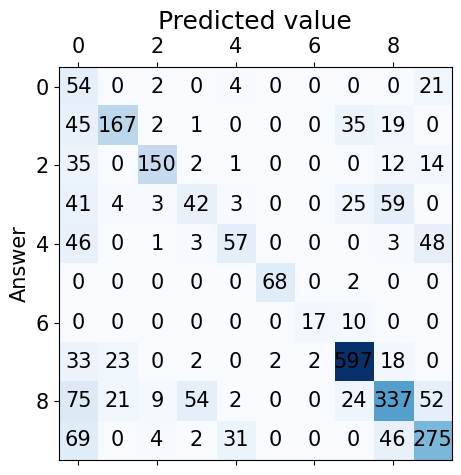

In [ ]:
#　ランダムフォレスト
# 予測値を作成
y_pred_forest = random_forest.predict(X_test)

# 混同行列を作成
conf_mat_forest = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_forest, axis=1)) # confusion_matrixはワンホットベクトルではなく整数値によるカテゴリしか受け付けないので，aumpyのargmaxを利用して変換している

# プロット
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_mat_forest, cmap=plt.cm.Blues)
for i in range(conf_mat_forest.shape[0]):
    for j in range(conf_mat_forest.shape[1]):
        ax.text(x=j, y=i, s=conf_mat_forest[i, j], va='center', ha='center')
plt.title('Predicted value')
plt.ylabel('Answer')
plt.rcParams["font.size"] = 15
plt.tight_layout()
plt.show()

## 正解率（Accuracy）

正解率とは「全体に対する正解の割合」であり，全てのテストデータのうち正解できた割合を指す．


正解率についての計算は一意に定めることができ，scikit-learnの`sklearn.metrics`モジュールを利用することで以下のように簡単に計算することができる．




In [ ]:
print("決定木")
print(f"正解率（Accuracy）: {accuracy_score(y_test, y_pred_tree)}")
print()
print("ランダムフォレスト")
print(f"正解率（Accuracy）: {accuracy_score(y_test, y_pred_forest)}")

決定木
正解率（Accuracy）: 0.6387434554973822

ランダムフォレスト
正解率（Accuracy）: 0.6537023186237846


## 適合率（Precision）
適合率とは「陽性と判定されたうち真の値が陽性である割合」であり，「どのクラスを陽性として扱うか」，「どのクラスを陰性として扱うか」によって値が変わってくる関係で計算の手法がいくつかある．

例えば

「各クラスごとに，自身を陽性，それ以外を全て陰性として（One vs Rest/OvR）適合率・再現率を計算してから平均をとる（マクロ平均）」のか，

「各クラスについてのTP/FP/FNの数を計算してからそれらの値を使ってモデル全体の適合率/再現率を計算する（マイクロ平均）」のかなどから手法を選ぶ必要がある．

マクロ平均で計算する場合は以下のように計算することができる．

In [ ]:
print("決定木")
print(f"適合率(Precision): {precision_score(y_test, y_pred_tree, average='macro')}")
print()
print("ランダムフォレスト")
print(f"適合率(Precision): {precision_score(y_test, y_pred_forest, average='macro')}")

決定木
適合率(Precision): 0.6688753684381503

ランダムフォレスト
適合率(Precision): 0.7416055157502504


マイクロ平均を利用する場合は，引数の値を変えることで以下のように計算することができる．

In [ ]:
print("決定木")
print(f"適合率(Precision): {precision_score(y_test, y_pred_tree, average='micro')}")
print()
print("ランダムフォレスト")
print(f"適合率(Precision): {precision_score(y_test, y_pred_forest, average='micro')}")

決定木
適合率(Precision): 0.6962902568283734

ランダムフォレスト
適合率(Precision): 0.7502145922746781


## 再現率（Recall）

再現率とは「真の値が陽性のうち，陽性と判定されたものの割合」である．

再現率の値も以下のように適合率と同様に計算することができる．

In [ ]:
# マクロ平均
print("決定木")
print(f"再現率(Recall): {recall_score(y_test, y_pred_tree, average='macro')}")
print()
print("ランダムフォレスト")
print(f"適合率(Precision): {recall_score(y_test, y_pred_forest, average='macro')}")



決定木
再現率(Recall): 0.6103406049025308

ランダムフォレスト
適合率(Precision): 0.6102961783122959


In [ ]:
# マイクロ平均
print("決定木")
print(f"再現率(Recall): {recall_score(y_test, y_pred_tree, average='micro')}")
print()
print("ランダムフォレスト")
print(f"適合率(Precision): {recall_score(y_test, y_pred_forest, average='micro')}")

決定木
再現率(Recall): 0.6387434554973822

ランダムフォレスト
適合率(Precision): 0.6537023186237846
